In [186]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [187]:
X = np.load('../data/X.npy')
X = torch.tensor(X, dtype=torch.float32)
y = np.load('../data/y.npy')
y = torch.tensor(y, dtype=torch.float32)
X = X[y == 0]
X = (X - X.min()) / (X.max() - X.min())

In [188]:
def auto_cov(X, lag=1):
    X = X - torch.mean(X, axis=0)
    if lag == 0:
        return torch.sum(X * X, axis=1)
    else:
        return (X[:, lag:] * X[:, :-lag]).sum(axis=1)

def auto_corr(X, lag=1):
    return auto_cov(X, lag) / auto_cov(X, 0)
a = auto_corr(X).mean()
m = X.mean()
s = X.std()
a, m, s

(tensor(0.9858), tensor(0.3147), tensor(0.2253))

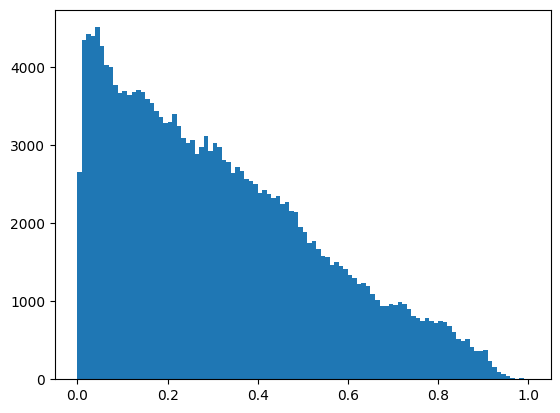

In [189]:
plt.hist(X.flatten(), bins=100);

In [194]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(100, 1152)
        self.conv_t1 = nn.ConvTranspose1d(12, 12, 3, 1, 1)
        self.conv_t2 = nn.ConvTranspose1d(12, 12, 3, 1, 1)
        self.conv_t3 = nn.ConvTranspose1d(12, 12, 3, 1, 1)
        self.conv_t4 = nn.ConvTranspose1d(12, 1, 3, 1, 1)
        self.batch_norm = nn.BatchNorm1d(96)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(-1, 12, 96)
        x = F.relu(self.conv_t1(x))
        x = F.relu(self.conv_t2(x))
        x = F.relu(self.conv_t3(x))
        x = self.conv_t4(x)
        x = x.view(-1, 96)
        x = self.batch_norm(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(1, 12, 3, 1, 1)
        self.conv2 = nn.Conv1d(12, 12, 3, 1, 1)
        self.conv3 = nn.Conv1d(12, 12, 3, 1, 1)
        self.conv4 = nn.Conv1d(12, 4, 3, 1, 1)
        self.fc = nn.Linear(384, 1)

    def forward(self, x):
        x = x.view(-1, 1, 96)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 384)
        x = F.sigmoid(self.fc(x))
        return x

In [195]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.conv_1 = nn.Conv1d(1, 8, 3, 1, 0)
#         self.conv_2 = nn.Conv1d(8, 16, 3, 1, 0)
#         self.conv_3 = nn.Conv1d(16, 32, 3, 1, 1)
#         self.conv_4 = nn.Conv1d(32, 64, 3, 1, 1)
#         self.conv_5 = nn.Conv1d(64, 1, 1, 1, 0)
#         self.batch_norm = nn.BatchNorm1d(96)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = x.view(-1, 1, 100)
#         x = F.relu(self.conv_1(x))
#         x = self.dropout(x)
#         x = F.relu(self.conv_2(x))
#         x = self.dropout(x)
#         x = F.relu(self.conv_3(x))
#         x = self.dropout(x)
#         x = F.relu(self.conv_4(x))
#         x = self.conv_5(x)
#         x = x.view(-1, 96)
#         x = self.batch_norm(x)
#         return x**2

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.pool = nn.MaxPool1d(2)
#         self.conv1 = nn.Conv1d(1, 8, 3, 1, 1)
#         self.conv2 = nn.Conv1d(8, 16, 3, 1, 1)
#         self.conv3 = nn.Conv1d(16, 32, 3, 1, 1)
#         self.conv4 = nn.Conv1d(32, 64, 3, 1, 1)
#         self.fc1 = nn.Linear(64*6, 128)
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = x.view(-1, 1, 96)
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = x.view(-1, 64*6)
#         x = F.relu(self.fc1(x))
#         x = F.sigmoid(self.fc2(x))
#         return x

In [196]:
dataloader = DataLoader(X.unsqueeze(1), batch_size=32, shuffle=True)

G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=1e-5)
optimizer_D = optim.Adam(D.parameters(), lr=1e-5)

n_sub_epochs = [(10, 20)]*20
num_epochs = sum([sum(sub_epoch) for sub_epoch in n_sub_epochs])
epoch = 0
best_score = float('inf')
for sub_epoch in n_sub_epochs:
    for _ in range(sub_epoch[0]):
        for real_data in dataloader:
            optimizer_D.zero_grad()
            real_data = real_data + 0.01 * torch.randn_like(real_data)
            D_real = D(real_data)
            D_real_loss = criterion(D_real, torch.ones_like(D_real))
            
            fake_data = G(torch.randn(32, 100))
            D_fake = D(fake_data.detach())
            D_fake_loss = criterion(D_fake, torch.zeros_like(D_fake))

            D_loss = D_real_loss + D_fake_loss
            D_loss.backward()
            optimizer_D.step()

        epoch += 1
        print(f"Epoch {epoch}/{num_epochs}, D Loss: {D_loss.item()}")

    for _ in range(sub_epoch[1]):
        for real_data in dataloader:
            optimizer_G.zero_grad()
            fake_data = G(torch.randn(32, 100))
            output = D(fake_data)
            
            G_loss = criterion(output, torch.ones_like(output))
            G_loss.backward()
            optimizer_G.step()

        epoch += 1
        print(f"Epoch {epoch}/{num_epochs}, G Loss: {G_loss.item()}")

    fake_data = G(torch.randn(1000, 100))
    a_fake = auto_corr(fake_data.squeeze()).mean()
    m_fake = fake_data.mean()
    s_fake = fake_data.std()
    print(f"a_fake: {a_fake}, m_fake: {m_fake}, s_fake: {s_fake}")
    score = (a_fake - a)**2 + (m_fake - m)**2 + (s_fake - s)**2
    if score < best_score:
        best_score = score
        best_G = G
        print(f"Best score: {score}")

Epoch 1/600, D Loss: 1.3888187408447266
Epoch 2/600, D Loss: 1.3879468441009521
Epoch 3/600, D Loss: 1.385312557220459
Epoch 4/600, D Loss: 1.3845477104187012
Epoch 5/600, D Loss: 1.3807811737060547
Epoch 6/600, D Loss: 1.3772072792053223
Epoch 7/600, D Loss: 1.3703007698059082
Epoch 8/600, D Loss: 1.3651635646820068
Epoch 9/600, D Loss: 1.3586111068725586
Epoch 10/600, D Loss: 1.351463794708252
Epoch 11/600, G Loss: 0.7001333832740784
Epoch 12/600, G Loss: 0.70218825340271
Epoch 13/600, G Loss: 0.700489342212677
Epoch 14/600, G Loss: 0.7001867890357971
Epoch 15/600, G Loss: 0.6990809440612793
Epoch 16/600, G Loss: 0.6986580491065979
Epoch 17/600, G Loss: 0.7003738880157471
Epoch 18/600, G Loss: 0.6995036602020264
Epoch 19/600, G Loss: 0.6989591717720032
Epoch 20/600, G Loss: 0.6961449384689331
Epoch 21/600, G Loss: 0.6983247995376587
Epoch 22/600, G Loss: 0.6967238187789917
Epoch 23/600, G Loss: 0.6973627805709839
Epoch 24/600, G Loss: 0.6987777352333069
Epoch 25/600, G Loss: 0.695854

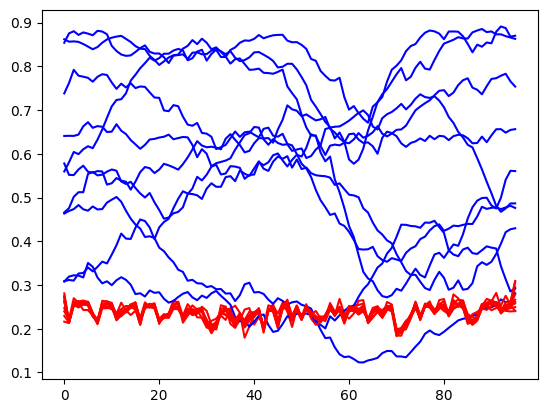

In [198]:
best_G.eval()
noise = torch.randn(10, 100)
fake_data = best_G(noise)
for i in range(10):
    plt.plot(fake_data[i].detach().numpy(), color='red')
    plt.plot(X[i].detach().numpy(), color='blue')
plt.show()

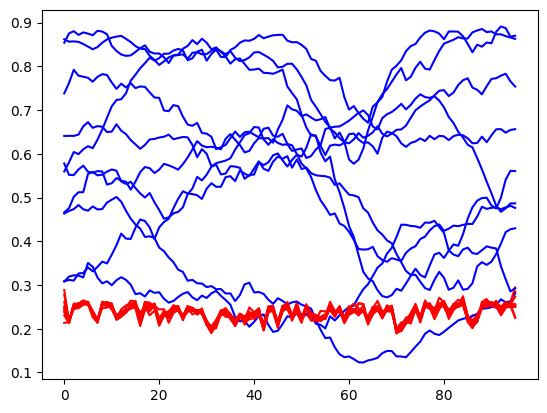

In [199]:
G.eval()
noise = torch.randn(10, 100)
fake_data = G(noise)
for i in range(10):
    plt.plot(fake_data[i].detach().numpy(), color='red')
    plt.plot(X[i].detach().numpy(), color='blue')
plt.show()

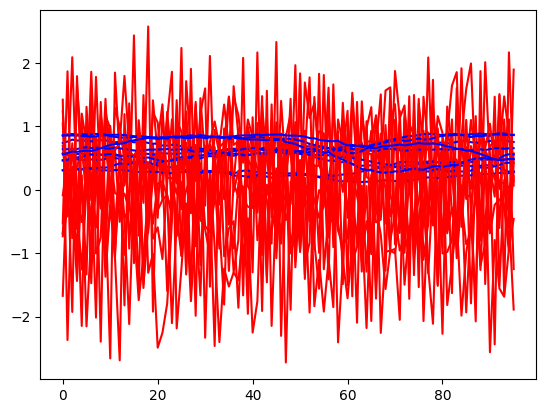

In [200]:
G2 = Generator()
noise = torch.randn(10, 100)
fake_data = G2(noise)
for i in range(10):
    plt.plot(fake_data[i].detach().numpy(), color='red')
    plt.plot(X[i].detach().numpy(), color='blue')
plt.show()